## 1. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Core ML
import xgboost as xgb
from sklearn.model_selection import (StratifiedKFold, cross_val_score,
                                     RandomizedSearchCV, train_test_split)
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                               StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.feature_selection import SelectFromModel

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False
sns.set_style("whitegrid")

print(" All imports ready")

XGBoost version : 3.2.0
✅ All imports ready


## 2. Load Data

In [2]:
train = pd.read_csv('ott_train.csv')
test  = pd.read_csv('ott_test.csv')

print(f"Train : {train.shape}")
print(f"Test  : {test.shape}")
print(f"Target balance:\n{train['fatigue_label'].value_counts(normalize=True).round(3)}")

Train : (8000, 15)
Test  : (2000, 14)
Target balance:
fatigue_label
0    0.646
1    0.354
Name: proportion, dtype: float64


## 2.1 Data Understanding & Visualisation

> Covers all EDA requirements from the competition brief:
> summary statistics · target distribution · feature-level patterns · correlations · tier analysis · outliers


In [ ]:
print("=" * 55)
print("DATASET OVERVIEW")
print("=" * 55)
print(f"  Training rows  : {len(train):,}")
print(f"  Test rows      : {len(test):,}")
print(f"  Features       : {train.shape[1] - 2}")  # minus user_id + label
print()

# Missing values
missing = train.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0] if missing.any() else "  No missing values found")
print()

# Duplicate check
print(f"Duplicate user IDs : {train['user_id'].duplicated().sum()}")
print()

# Statistical summary — numeric only
display(train.describe(include='number').round(2))


DATASET OVERVIEW
  Training rows  : 8,000
  Test rows      : 2,000
  Features       : 13

Missing values per column:
  ✅ No missing values found

Duplicate user IDs : 0



,tenure_days,avg_daily_minutes_last_7d,avg_daily_minutes_last_30d,sessions_last_7d,sessions_last_30d,avg_completion_rate,unique_genres_watched_30d,days_since_last_session,binge_sessions_last_30d,peak_hour_viewing_pct,original_content_pct,recommendation_click_rate,fatigue_label
count,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00
mean,175.12,57.30,60.91,5.19,21.06,0.39,3.90,1.92,1.56,71.46,45.65,0.21,0.35
std,173.33,40.71,46.46,2.54,10.58,0.18,2.19,2.50,1.55,15.80,19.51,0.13,0.48
min,7.00,0.00,5.00,0.00,0.00,0.05,1.00,0.00,0.00,9.80,1.10,0.02,0.00
25%,51.00,25.70,23.68,3.00,13.00,0.25,2.00,0.00,0.00,61.00,30.70,0.10,0.00
50%,121.00,53.90,53.40,5.00,20.00,0.37,4.00,1.00,1.00,73.40,45.00,0.20,0.00
75%,242.00,84.22,87.90,7.00,28.00,0.51,5.00,3.00,2.00,83.90,60.30,0.29,1.00
max,1095.00,214.80,300.00,17.00,75.00,0.98,15.00,30.00,11.00,95.00,90.00,0.70,1.00


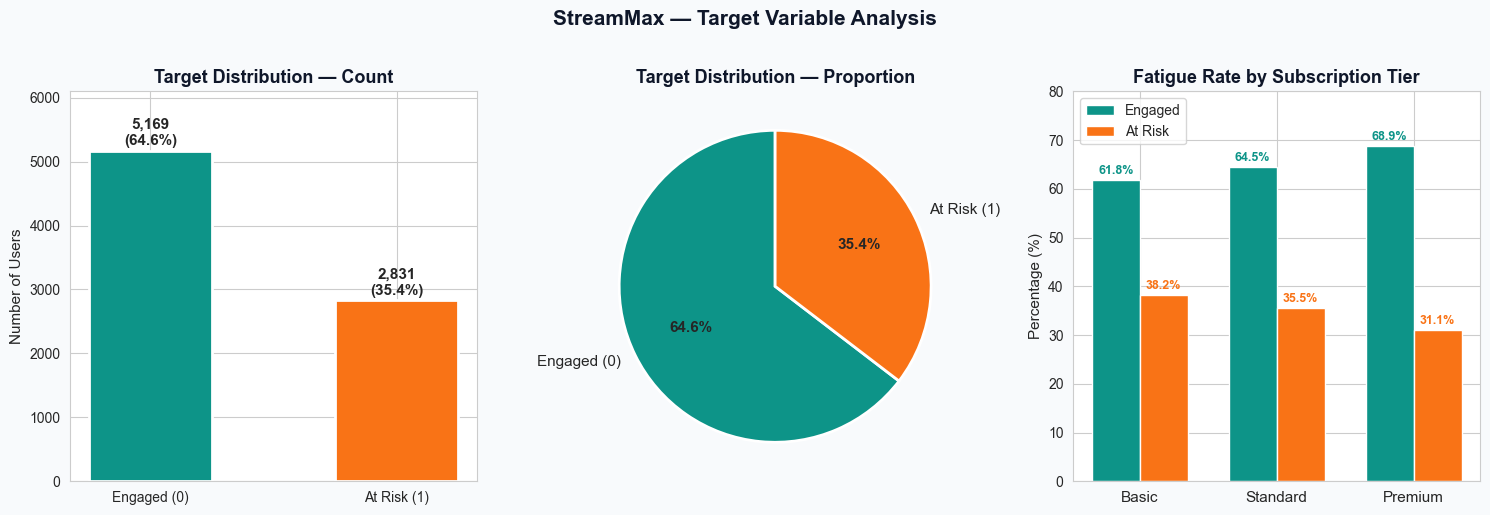

Key insight: Check if Basic tier has higher fatigue rate → tier-based intervention strategy


In [ ]:
# ─────────────────────────────────────────────
# VIZ 2 — Target Variable Distribution
# ─────────────────────────────────────────────
TEAL   = '#0D9488'
ORANGE = '#F97316'
NAVY   = '#0F172A'
SLATE  = '#475569'
LIGHT  = '#F8FAFC'

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor(LIGHT)

counts = train['fatigue_label'].value_counts().sort_index()
labels = ['Engaged (0)', 'At Risk (1)']
colors = [TEAL, ORANGE]

# -- Bar chart --
bars = axes[0].bar(labels, counts.values, color=colors,
                   edgecolor='white', linewidth=2, width=0.5)
axes[0].set_title('Target Distribution — Count', fontsize=13, fontweight='bold', color=NAVY)
axes[0].set_ylabel('Number of Users', fontsize=11)
for bar, v in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, v + 40,
                 f'{v:,}\n({v/len(train)*100:.1f}%)',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[0].set_ylim(0, counts.max() * 1.18)

# -- Pie chart --
wedges, texts, autotexts = axes[1].pie(
    counts.values, labels=labels, colors=colors,
    autopct='%1.1f%%', startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    textprops={'fontsize': 11}
)
for at in autotexts:
    at.set_fontweight('bold')
axes[1].set_title('Target Distribution — Proportion', fontsize=13, fontweight='bold', color=NAVY)

# -- Subscription tier breakdown --
tier_order = ['Basic', 'Standard', 'Premium']
tier_data  = (train.groupby(['subscription_tier', 'fatigue_label'])
                    .size().unstack(fill_value=0)
                    .reindex(tier_order))
tier_pct   = tier_data.div(tier_data.sum(axis=1), axis=0) * 100

x     = np.arange(len(tier_order))
width = 0.35
axes[2].bar(x - width/2, tier_pct[0], width, label='Engaged',  color=TEAL,   edgecolor='white')
axes[2].bar(x + width/2, tier_pct[1], width, label='At Risk',  color=ORANGE, edgecolor='white')
axes[2].set_xticks(x)
axes[2].set_xticklabels(tier_order, fontsize=11)
axes[2].set_ylabel('Percentage (%)', fontsize=11)
axes[2].set_title('Fatigue Rate by Subscription Tier', fontsize=13, fontweight='bold', color=NAVY)
axes[2].legend(fontsize=10)
axes[2].set_ylim(0, 80)
for i, tier in enumerate(tier_order):
    axes[2].text(i - width/2, tier_pct.loc[tier, 0] + 1.2,
                 f"{tier_pct.loc[tier, 0]:.1f}%", ha='center', fontsize=9, color=TEAL, fontweight='bold')
    axes[2].text(i + width/2, tier_pct.loc[tier, 1] + 1.2,
                 f"{tier_pct.loc[tier, 1]:.1f}%", ha='center', fontsize=9, color=ORANGE, fontweight='bold')

plt.suptitle('StreamMax — Target Variable Analysis', fontsize=15, fontweight='bold',
             color=NAVY, y=1.02)
plt.tight_layout()
plt.savefig('viz_01_target_distribution.png', dpi=130, bbox_inches='tight')
plt.show()
print("Key insight: Check if Basic tier has higher fatigue rate → tier-based intervention strategy")


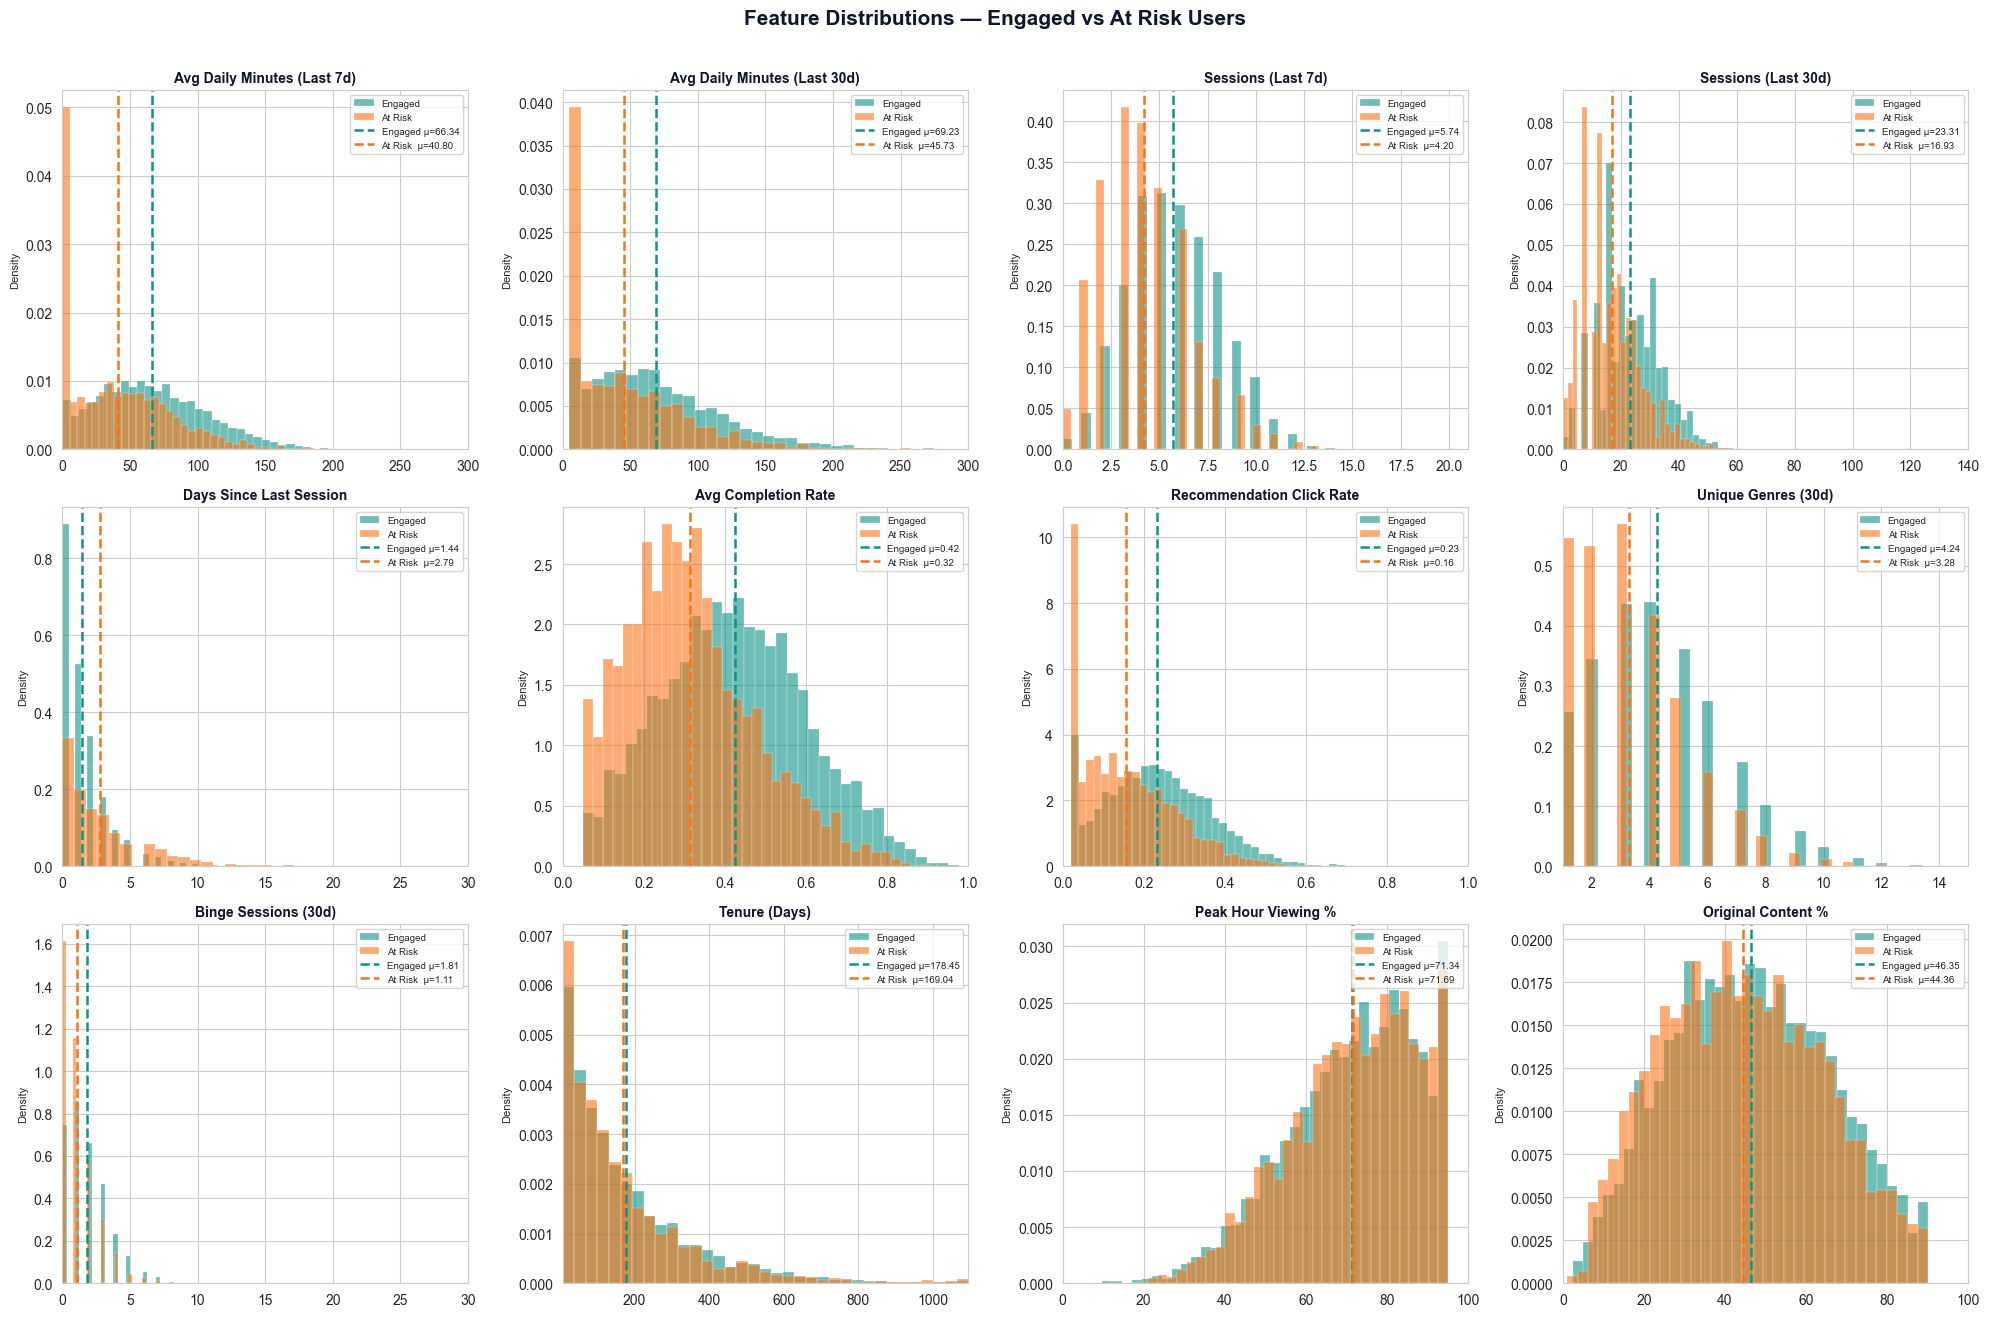

Key insight: Features with the LEAST overlap between distributions are your strongest predictors


In [5]:
# ─────────────────────────────────────────────
# VIZ 3 — Key Feature Distributions by Label
# ─────────────────────────────────────────────
key_features = [
    ('avg_daily_minutes_last_7d',  'Avg Daily Minutes (Last 7d)',    0,   300),
    ('avg_daily_minutes_last_30d', 'Avg Daily Minutes (Last 30d)',   0,   300),
    ('sessions_last_7d',           'Sessions (Last 7d)',             0,    21),
    ('sessions_last_30d',          'Sessions (Last 30d)',            0,   140),
    ('days_since_last_session',    'Days Since Last Session',        0,    30),
    ('avg_completion_rate',        'Avg Completion Rate',            0,     1),
    ('recommendation_click_rate',  'Recommendation Click Rate',      0,     1),
    ('unique_genres_watched_30d',  'Unique Genres (30d)',            1,    15),
    ('binge_sessions_last_30d',    'Binge Sessions (30d)',           0,    30),
    ('tenure_days',                'Tenure (Days)',                  7,  1095),
    ('peak_hour_viewing_pct',      'Peak Hour Viewing %',            0,   100),
    ('original_content_pct',       'Original Content %',             0,   100),
]

engaged  = train[train['fatigue_label'] == 0]
fatigued = train[train['fatigue_label'] == 1]

fig, axes = plt.subplots(3, 4, figsize=(20, 13))
axes = axes.flatten()

for i, (col, label, xmin, xmax) in enumerate(key_features):
    ax = axes[i]
    ax.hist(engaged[col],  bins=35, alpha=0.60, color=TEAL,   density=True,
            label='Engaged',  edgecolor='white', linewidth=0.3)
    ax.hist(fatigued[col], bins=35, alpha=0.60, color=ORANGE, density=True,
            label='At Risk',  edgecolor='white', linewidth=0.3)

    # Mean lines
    ax.axvline(engaged[col].mean(),  color=TEAL,   linestyle='--', linewidth=1.8,
               label=f'Engaged μ={engaged[col].mean():.2f}')
    ax.axvline(fatigued[col].mean(), color=ORANGE, linestyle='--', linewidth=1.8,
               label=f'At Risk  μ={fatigued[col].mean():.2f}')

    ax.set_title(label, fontsize=10, fontweight='bold', color=NAVY)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('')
    ax.set_ylabel('Density', fontsize=8)
    ax.legend(fontsize=7, loc='upper right')

plt.suptitle('Feature Distributions — Engaged vs At Risk Users',
             fontsize=15, fontweight='bold', color=NAVY, y=1.01)
plt.tight_layout()
plt.savefig('viz_02_feature_distributions.png', dpi=130, bbox_inches='tight')
plt.show()
print("Key insight: Features with the LEAST overlap between distributions are your strongest predictors")


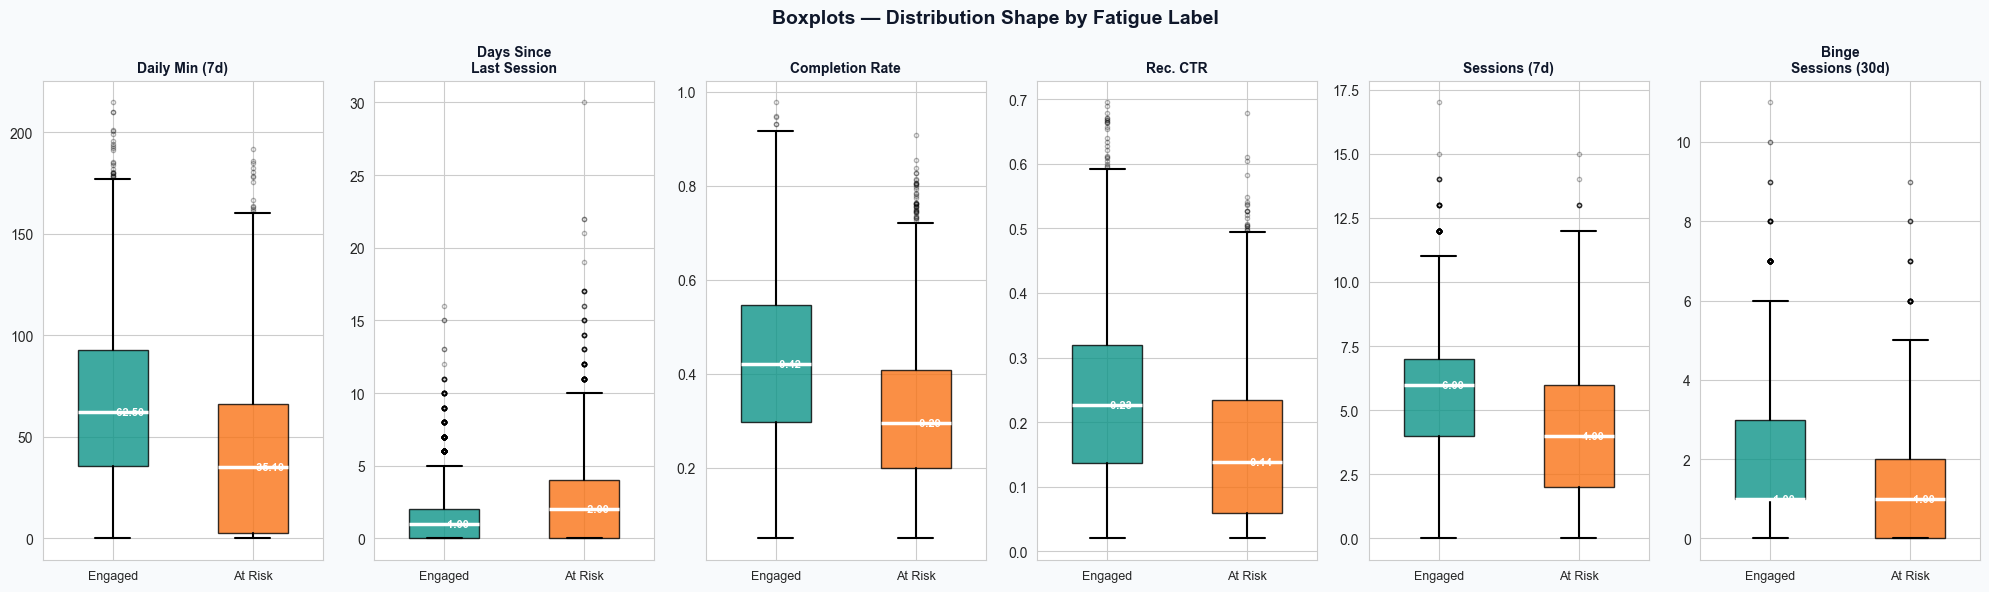

Key insight: Larger gap between box positions = stronger predictor of fatigue


In [6]:
# ─────────────────────────────────────────────
# VIZ 4 — Boxplots: Engaged vs At Risk
# Reveals medians, IQR, and outliers cleanly
# ─────────────────────────────────────────────
box_features = [
    'avg_daily_minutes_last_7d', 'days_since_last_session',
    'avg_completion_rate',        'recommendation_click_rate',
    'sessions_last_7d',           'binge_sessions_last_30d',
]
box_labels = [
    'Daily Min (7d)', 'Days Since\nLast Session',
    'Completion Rate', 'Rec. CTR',
    'Sessions (7d)', 'Binge\nSessions (30d)',
]

fig, axes = plt.subplots(1, 6, figsize=(20, 6))
fig.patch.set_facecolor(LIGHT)

for i, (col, lbl) in enumerate(zip(box_features, box_labels)):
    data = [engaged[col].values, fatigued[col].values]
    bp   = axes[i].boxplot(data, patch_artist=True, widths=0.5,
                            medianprops={'color': 'white', 'linewidth': 2.5},
                            whiskerprops={'linewidth': 1.5},
                            capprops={'linewidth': 1.5},
                            flierprops={'marker': 'o', 'markersize': 3, 'alpha': 0.3})
    bp['boxes'][0].set_facecolor(TEAL)
    bp['boxes'][0].set_alpha(0.8)
    bp['boxes'][1].set_facecolor(ORANGE)
    bp['boxes'][1].set_alpha(0.8)

    axes[i].set_xticklabels(['Engaged', 'At Risk'], fontsize=9)
    axes[i].set_title(lbl, fontsize=10, fontweight='bold', color=NAVY)
    axes[i].set_ylabel('')

    # Annotate medians
    for j, d in enumerate(data):
        med = np.median(d)
        axes[i].text(j + 1, med, f' {med:.2f}', va='center', fontsize=8,
                     color='white', fontweight='bold')

plt.suptitle('Boxplots — Distribution Shape by Fatigue Label',
             fontsize=14, fontweight='bold', color=NAVY)
plt.tight_layout()
plt.savefig('viz_03_boxplots.png', dpi=130, bbox_inches='tight')
plt.show()
print("Key insight: Larger gap between box positions = stronger predictor of fatigue")


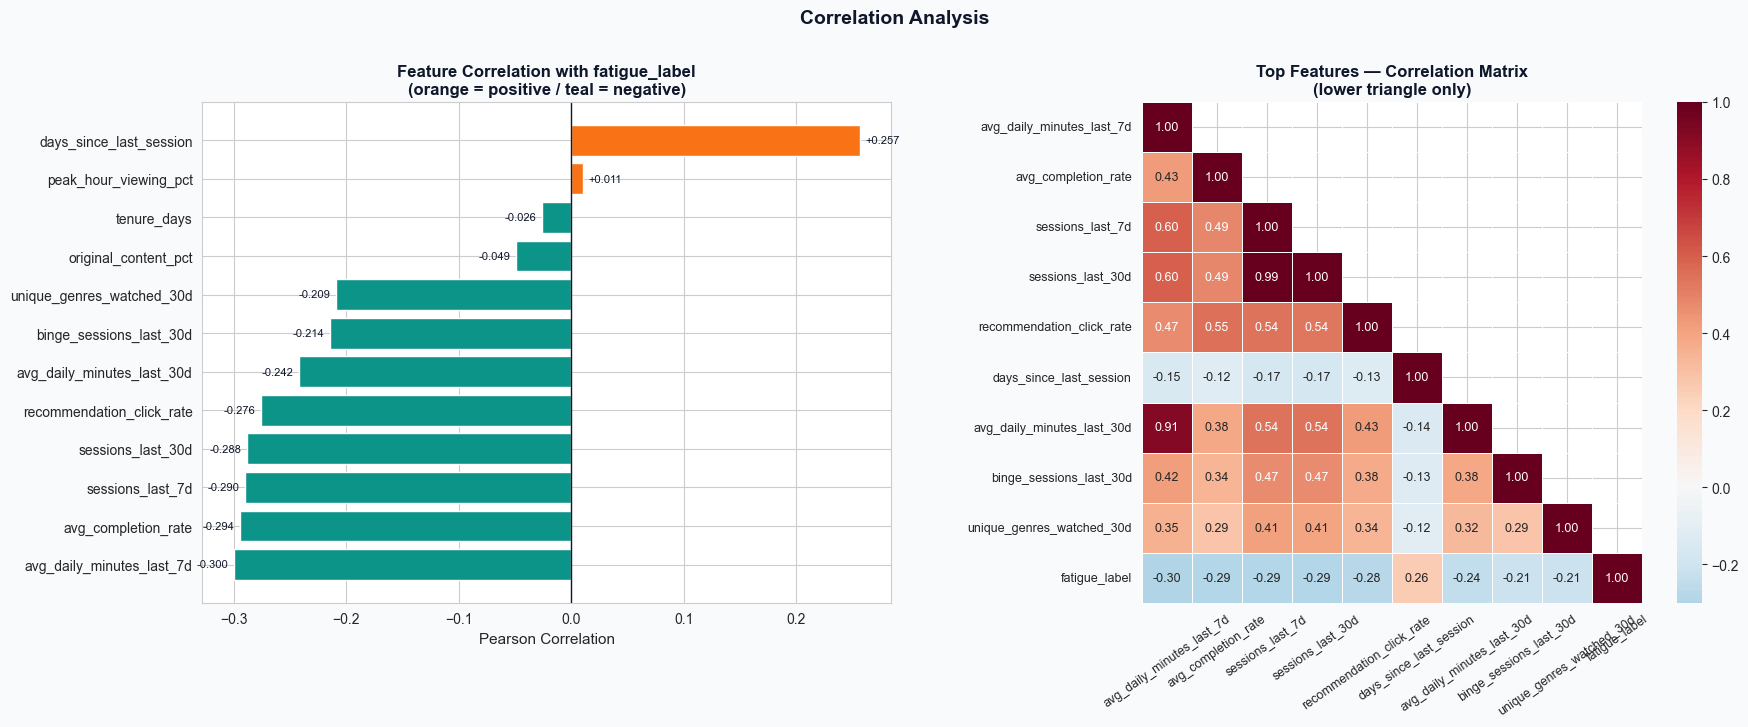

Top 5 features most correlated with fatigue_label:
avg_daily_minutes_last_7d    0.3000
avg_completion_rate          0.2942
sessions_last_7d             0.2898
sessions_last_30d            0.2883
recommendation_click_rate    0.2755


In [7]:
# ─────────────────────────────────────────────
# VIZ 5 — Correlation Heatmap
# ─────────────────────────────────────────────
numeric_cols = train.select_dtypes(include='number').drop(columns=['fatigue_label'])

# Correlation with target — ranked
corr_target = (train[numeric_cols.columns.tolist() + ['fatigue_label']]
               .corr()['fatigue_label']
               .drop('fatigue_label')
               .sort_values())

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.patch.set_facecolor(LIGHT)

# -- Bar: correlation with fatigue_label --
bar_colors = [ORANGE if v > 0 else TEAL for v in corr_target.values]
axes[0].barh(corr_target.index, corr_target.values, color=bar_colors, edgecolor='white')
axes[0].axvline(0, color=NAVY, linewidth=1)
axes[0].set_title('Feature Correlation with fatigue_label\n(orange = positive / teal = negative)',
                   fontsize=12, fontweight='bold', color=NAVY)
axes[0].set_xlabel('Pearson Correlation', fontsize=11)
for i, (idx, val) in enumerate(corr_target.items()):
    axes[0].text(val + (0.005 if val >= 0 else -0.005), i,
                 f'{val:+.3f}', va='center', ha='left' if val >= 0 else 'right',
                 fontsize=8, color=NAVY)

# -- Heatmap: top 10 features + target --
top_feats = corr_target.abs().nlargest(9).index.tolist() + ['fatigue_label']
corr_mat  = train[top_feats].corr()
mask      = np.zeros_like(corr_mat, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

sns.heatmap(corr_mat, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=axes[1], square=True, linewidths=0.5, linecolor='white',
            mask=mask, annot_kws={'size': 9})
axes[1].set_title('Top Features — Correlation Matrix\n(lower triangle only)',
                   fontsize=12, fontweight='bold', color=NAVY)
axes[1].tick_params(axis='x', rotation=35, labelsize=9)
axes[1].tick_params(axis='y', rotation=0,  labelsize=9)

plt.suptitle('Correlation Analysis', fontsize=14, fontweight='bold', color=NAVY, y=1.01)
plt.tight_layout()
plt.savefig('viz_04_correlations.png', dpi=130, bbox_inches='tight')
plt.show()

print("Top 5 features most correlated with fatigue_label:")
print(corr_target.abs().nlargest(5).round(4).to_string())


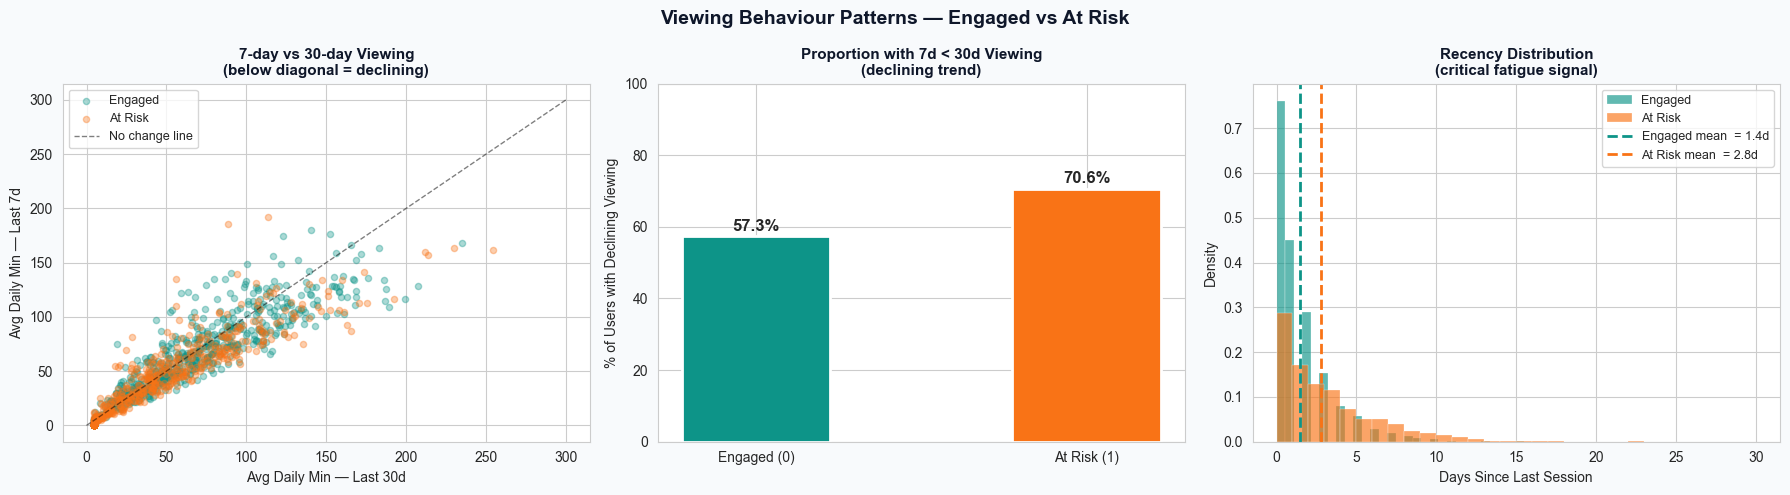

In [8]:
# ─────────────────────────────────────────────
# VIZ 6 — Viewing Decline Pattern
# 7d vs 30d minutes coloured by fatigue label
# ─────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor(LIGHT)

# -- Scatter: 7d vs 30d minutes --
sample_e = engaged.sample(min(600, len(engaged)),   random_state=42)
sample_f = fatigued.sample(min(600, len(fatigued)), random_state=42)

axes[0].scatter(sample_e['avg_daily_minutes_last_30d'], sample_e['avg_daily_minutes_last_7d'],
                alpha=0.35, color=TEAL,   s=20, label='Engaged')
axes[0].scatter(sample_f['avg_daily_minutes_last_30d'], sample_f['avg_daily_minutes_last_7d'],
                alpha=0.35, color=ORANGE, s=20, label='At Risk')
axes[0].plot([0, 300], [0, 300], 'k--', linewidth=1, alpha=0.5, label='No change line')
axes[0].set_xlabel('Avg Daily Min — Last 30d', fontsize=10)
axes[0].set_ylabel('Avg Daily Min — Last 7d',  fontsize=10)
axes[0].set_title('7-day vs 30-day Viewing\n(below diagonal = declining)', fontsize=11, fontweight='bold', color=NAVY)
axes[0].legend(fontsize=9)

# -- Bar: % of users below diagonal (declining) --
train['viewing_declining'] = train['avg_daily_minutes_last_7d'] < train['avg_daily_minutes_last_30d']
dec = train.groupby('fatigue_label')['viewing_declining'].mean() * 100
axes[1].bar(['Engaged (0)', 'At Risk (1)'], dec.values,
            color=[TEAL, ORANGE], edgecolor='white', linewidth=2, width=0.45)
axes[1].set_ylabel('% of Users with Declining Viewing', fontsize=10)
axes[1].set_title('Proportion with 7d < 30d Viewing\n(declining trend)', fontsize=11, fontweight='bold', color=NAVY)
axes[1].set_ylim(0, 100)
for i, v in enumerate(dec.values):
    axes[1].text(i, v + 1.5, f'{v:.1f}%', ha='center', fontsize=12, fontweight='bold')

# -- Histogram: days since last session --
axes[2].hist(engaged['days_since_last_session'],  bins=30, alpha=0.65, color=TEAL,
             density=True, label='Engaged',  edgecolor='white', linewidth=0.3)
axes[2].hist(fatigued['days_since_last_session'], bins=30, alpha=0.65, color=ORANGE,
             density=True, label='At Risk',  edgecolor='white', linewidth=0.3)
axes[2].axvline(engaged['days_since_last_session'].mean(),  color=TEAL,   linestyle='--', lw=2,
                label=f"Engaged mean  = {engaged['days_since_last_session'].mean():.1f}d")
axes[2].axvline(fatigued['days_since_last_session'].mean(), color=ORANGE, linestyle='--', lw=2,
                label=f"At Risk mean  = {fatigued['days_since_last_session'].mean():.1f}d")
axes[2].set_xlabel('Days Since Last Session', fontsize=10)
axes[2].set_ylabel('Density', fontsize=10)
axes[2].set_title('Recency Distribution\n(critical fatigue signal)', fontsize=11, fontweight='bold', color=NAVY)
axes[2].legend(fontsize=9)

plt.suptitle('Viewing Behaviour Patterns — Engaged vs At Risk',
             fontsize=14, fontweight='bold', color=NAVY)
plt.tight_layout()
plt.savefig('viz_05_viewing_patterns.png', dpi=130, bbox_inches='tight')
plt.show()


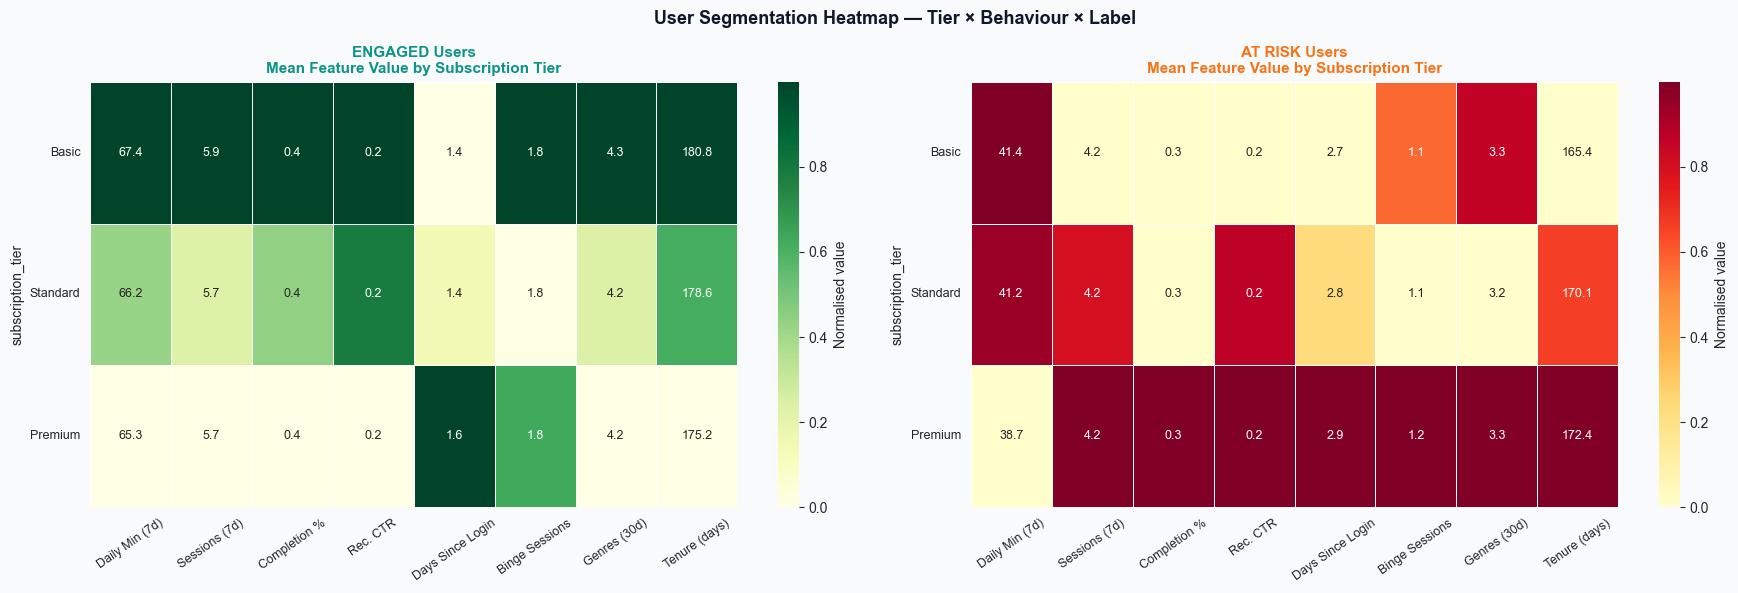

Key insight: Compare rows across both heatmaps to find tier-specific fatigue drivers


In [9]:
# ─────────────────────────────────────────────
# VIZ 7 — User Segmentation Heatmap
# Mean feature values per group: tier × label
# ─────────────────────────────────────────────
seg_features = [
    'avg_daily_minutes_last_7d', 'sessions_last_7d',
    'avg_completion_rate',        'recommendation_click_rate',
    'days_since_last_session',    'binge_sessions_last_30d',
    'unique_genres_watched_30d',  'tenure_days',
]
seg_labels = [
    'Daily Min (7d)', 'Sessions (7d)',
    'Completion %', 'Rec. CTR',
    'Days Since Login', 'Binge Sessions',
    'Genres (30d)', 'Tenure (days)',
]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.patch.set_facecolor(LIGHT)

for ax_idx, label_val in enumerate([0, 1]):
    subset = train[train['fatigue_label'] == label_val]
    pivot  = subset.groupby('subscription_tier')[seg_features].mean().reindex(['Basic','Standard','Premium'])
    pivot.columns = seg_labels

    # Normalise each column 0-1 for visual comparability
    pivot_norm = (pivot - pivot.min()) / (pivot.max() - pivot.min() + 1e-9)

    cmap  = 'YlOrRd' if label_val == 1 else 'YlGn'
    title = 'AT RISK Users' if label_val == 1 else 'ENGAGED Users'
    color = ORANGE         if label_val == 1 else TEAL

    sns.heatmap(pivot_norm, annot=pivot.round(1), fmt='.1f',
                cmap=cmap, ax=axes[ax_idx], linewidths=0.5,
                linecolor='white', cbar_kws={'label': 'Normalised value'},
                annot_kws={'size': 9})
    axes[ax_idx].set_title(f'{title}\nMean Feature Value by Subscription Tier',
                            fontsize=11, fontweight='bold', color=color)
    axes[ax_idx].set_xlabel('')
    axes[ax_idx].tick_params(axis='x', rotation=35, labelsize=9)
    axes[ax_idx].tick_params(axis='y', rotation=0,  labelsize=9)

plt.suptitle('User Segmentation Heatmap — Tier × Behaviour × Label',
             fontsize=13, fontweight='bold', color=NAVY)
plt.tight_layout()
plt.savefig('viz_06_segmentation_heatmap.png', dpi=130, bbox_inches='tight')
plt.show()
print("Key insight: Compare rows across both heatmaps to find tier-specific fatigue drivers")


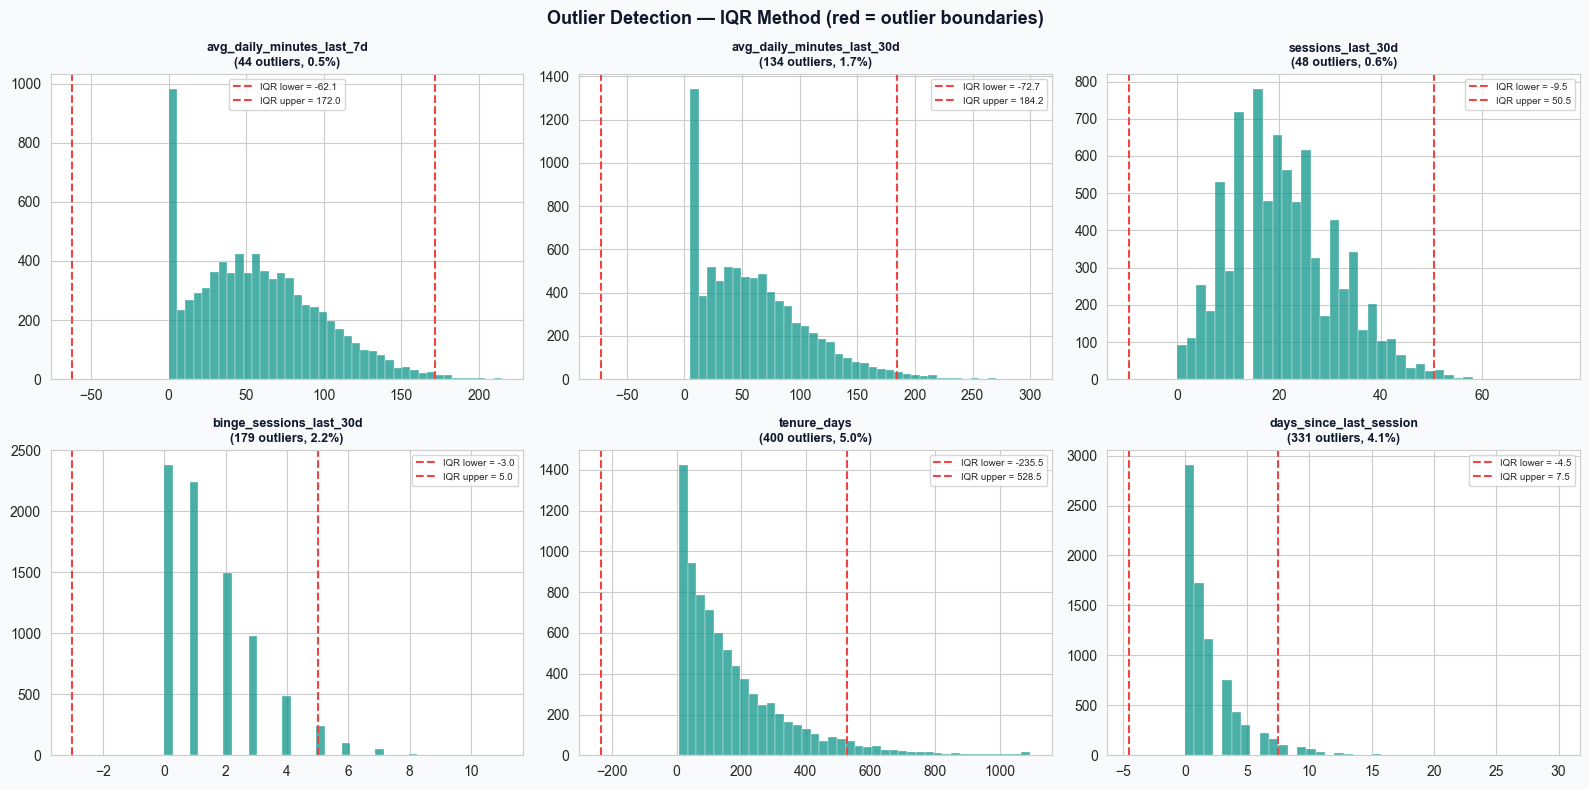

Outlier counts (IQR method):
  avg_daily_minutes_last_7d               :   44 (0.5%)
  avg_daily_minutes_last_30d              :  134 (1.7%)
  sessions_last_30d                       :   48 (0.6%)
  binge_sessions_last_30d                 :  179 (2.2%)
  tenure_days                             :  400 (5.0%)
  days_since_last_session                 :  331 (4.1%)

✅ Note: XGBoost is robust to outliers — no clipping needed for tree models


In [ ]:
# ─────────────────────────────────────────────
# VIZ 8 — Outlier Detection (IQR method)
# ─────────────────────────────────────────────
outlier_cols = [
    'avg_daily_minutes_last_7d', 'avg_daily_minutes_last_30d',
    'sessions_last_30d',          'binge_sessions_last_30d',
    'tenure_days',                'days_since_last_session',
]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()
fig.patch.set_facecolor(LIGHT)

outlier_summary = {}
for i, col in enumerate(outlier_cols):
    Q1, Q3 = train[col].quantile(0.25), train[col].quantile(0.75)
    IQR     = Q3 - Q1
    lower   = Q1 - 1.5 * IQR
    upper   = Q3 + 1.5 * IQR
    n_out   = ((train[col] < lower) | (train[col] > upper)).sum()
    outlier_summary[col] = n_out

    axes[i].hist(train[col], bins=40, color=TEAL, alpha=0.75, edgecolor='white', linewidth=0.3)
    axes[i].axvline(lower, color='#EF4444', linestyle='--', lw=1.5, label=f'IQR lower = {lower:.1f}')
    axes[i].axvline(upper, color='#EF4444', linestyle='--', lw=1.5, label=f'IQR upper = {upper:.1f}')
    axes[i].set_title(f'{col}\n({n_out} outliers, {n_out/len(train)*100:.1f}%)',
                      fontsize=9, fontweight='bold', color=NAVY)
    axes[i].legend(fontsize=7)

plt.suptitle('Outlier Detection — IQR Method (red = outlier boundaries)',
             fontsize=13, fontweight='bold', color=NAVY)
plt.tight_layout()
plt.savefig('viz_07_outliers.png', dpi=130, bbox_inches='tight')
plt.show()

print("Outlier counts (IQR method):")
for col, n in outlier_summary.items():
    print(f"  {col:<40}: {n:>4} ({n/len(train)*100:.1f}%)")
print("\n Note: XGBoost is robust to outliers — no clipping needed for tree models")


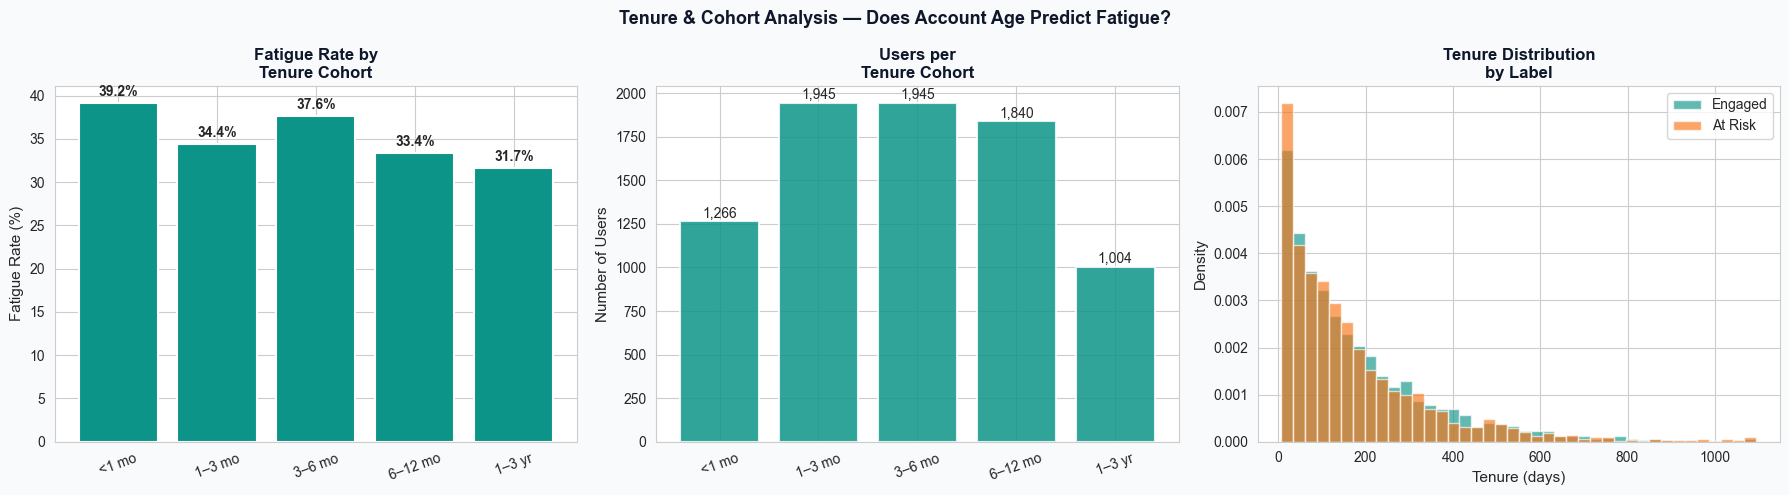

In [11]:
# ─────────────────────────────────────────────
# VIZ 9 — Tenure Distribution & Cohort Analysis
# New vs long-term users behave differently
# ─────────────────────────────────────────────
train['tenure_bucket'] = pd.cut(
    train['tenure_days'],
    bins=[0, 30, 90, 180, 365, 1095],
    labels=['<1 mo', '1–3 mo', '3–6 mo', '6–12 mo', '1–3 yr']
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor(LIGHT)

# -- Fatigue rate by tenure bucket --
tenure_fatigue = (train.groupby('tenure_bucket', observed=True)['fatigue_label']
                       .mean() * 100)
axes[0].bar(tenure_fatigue.index, tenure_fatigue.values,
            color=[ORANGE if v > 40 else TEAL for v in tenure_fatigue.values],
            edgecolor='white', linewidth=1.5)
axes[0].set_ylabel('Fatigue Rate (%)', fontsize=11)
axes[0].set_title('Fatigue Rate by\nTenure Cohort', fontsize=12, fontweight='bold', color=NAVY)
for i, v in enumerate(tenure_fatigue.values):
    axes[0].text(i, v + 0.8, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')
axes[0].tick_params(axis='x', rotation=20)

# -- User count per bucket --
tenure_count = train.groupby('tenure_bucket', observed=True).size()
axes[1].bar(tenure_count.index, tenure_count.values,
            color=TEAL, edgecolor='white', linewidth=1.5, alpha=0.85)
axes[1].set_ylabel('Number of Users', fontsize=11)
axes[1].set_title('Users per\nTenure Cohort', fontsize=12, fontweight='bold', color=NAVY)
for i, v in enumerate(tenure_count.values):
    axes[1].text(i, v + 20, f'{v:,}', ha='center', fontsize=10)
axes[1].tick_params(axis='x', rotation=20)

# -- Tenure histogram by label --
axes[2].hist(engaged['tenure_days'],  bins=40, alpha=0.65, color=TEAL,
             density=True, label='Engaged', edgecolor='white')
axes[2].hist(fatigued['tenure_days'], bins=40, alpha=0.65, color=ORANGE,
             density=True, label='At Risk', edgecolor='white')
axes[2].set_xlabel('Tenure (days)', fontsize=11)
axes[2].set_ylabel('Density', fontsize=11)
axes[2].set_title('Tenure Distribution\nby Label', fontsize=12, fontweight='bold', color=NAVY)
axes[2].legend(fontsize=10)

plt.suptitle('Tenure & Cohort Analysis — Does Account Age Predict Fatigue?',
             fontsize=13, fontweight='bold', color=NAVY)
plt.tight_layout()
plt.savefig('viz_08_tenure_cohorts.png', dpi=130, bbox_inches='tight')
plt.show()
# Drop temp column so it doesn't interfere with later steps
train.drop(columns=['viewing_declining', 'tenure_bucket'], inplace=True, errors='ignore')


## 3. Advanced Feature Engineering (40+ features)

XGBoost handles raw features well, but **interaction features and ratio features** 
still help because they express domain knowledge the model can't derive from scratch.


In [ ]:
def engineer_features(df):
    df = df.copy()

    # ── Tier encoding ──
    df['tier_encoded'] = df['subscription_tier'].map({'Basic':0,'Standard':1,'Premium':2})

    # ── Viewing trend (direction of change) ──
    df['viewing_trend_abs']    = df['avg_daily_minutes_last_7d'] - df['avg_daily_minutes_last_30d']
    df['viewing_trend_ratio']  = np.where(df['avg_daily_minutes_last_30d'] > 0,
                                           df['avg_daily_minutes_last_7d'] / df['avg_daily_minutes_last_30d'], 0)
    df['session_trend_abs']    = (df['sessions_last_7d'] * (30/7)) - df['sessions_last_30d']
    df['session_trend_ratio']  = np.where(df['sessions_last_30d'] > 0,
                                           (df['sessions_last_7d'] * (30/7)) / df['sessions_last_30d'], 0)

    # ── Recency (exponential decay — 3 half-lives) ──
    df['recency_decay_3d']     = np.exp(-df['days_since_last_session'] / 3)
    df['recency_decay_7d']     = np.exp(-df['days_since_last_session'] / 7)
    df['recency_decay_14d']    = np.exp(-df['days_since_last_session'] / 14)

    # ── Recency binary flags ──
    df['absent_3d']            = (df['days_since_last_session'] >= 3).astype(int)
    df['absent_7d']            = (df['days_since_last_session'] >= 7).astype(int)
    df['absent_14d']           = (df['days_since_last_session'] >= 14).astype(int)
    df['zero_sessions_7d']     = (df['sessions_last_7d'] == 0).astype(int)

    # ── Session intensity ──
    df['mins_per_session_7d']  = np.where(df['sessions_last_7d'] > 0,
                                           df['avg_daily_minutes_last_7d'] * 7 / df['sessions_last_7d'], 0)
    df['mins_per_session_30d'] = np.where(df['sessions_last_30d'] > 0,
                                           df['avg_daily_minutes_last_30d'] * 30 / df['sessions_last_30d'], 0)
    df['total_watch_7d']       = df['avg_daily_minutes_last_7d'] * 7
    df['total_watch_30d']      = df['avg_daily_minutes_last_30d'] * 30

    # ── Binge behaviour ──
    df['binge_ratio']          = np.where(df['sessions_last_30d'] > 0,
                                           df['binge_sessions_last_30d'] / df['sessions_last_30d'], 0)
    df['zero_binge']           = (df['binge_sessions_last_30d'] == 0).astype(int)

    # ── Content diversity ──
    df['content_breadth']      = df['unique_genres_watched_30d'] / 15

    # ── Composite engagement scores ──
    df['engagement_score']     = (df['recency_decay_7d']          * 0.30 +
                                   df['avg_completion_rate']       * 0.25 +
                                   df['recommendation_click_rate'] * 0.20 +
                                   df['binge_ratio']               * 0.15 +
                                   df['content_breadth']           * 0.10)

    df['content_satisfaction'] = (df['avg_completion_rate']        * 0.5 +
                                   df['recommendation_click_rate'] * 0.5)

    # ── INTERACTION FEATURES (key for XGBoost too) ──
    df['absent_x_low_completion']  = df['days_since_last_session'] * (1 - df['avg_completion_rate'])
    df['absent_x_low_ctr']         = df['days_since_last_session'] * (1 - df['recommendation_click_rate'])
    df['low_7d_drop']              = (df['avg_daily_minutes_last_30d'] - df['avg_daily_minutes_last_7d']).clip(0)
    df['sessions_x_completion']    = df['sessions_last_30d']       * df['avg_completion_rate']
    df['binge_x_completion']       = df['binge_sessions_last_30d'] * df['avg_completion_rate']
    df['tenure_x_engagement']      = np.log1p(df['tenure_days'])   * df['engagement_score']
    df['recency_x_sessions']       = df['recency_decay_7d']        * df['sessions_last_7d']

    # ── Risk flag aggregation (count of red flags) ──
    df['flag_low_minutes']         = (df['avg_daily_minutes_last_7d']  <  10).astype(int)
    df['flag_low_completion']      = (df['avg_completion_rate']        < 0.3).astype(int)
    df['flag_low_ctr']             = (df['recommendation_click_rate']  < 0.1).astype(int)
    df['flag_low_genres']          = (df['unique_genres_watched_30d']  <=  2).astype(int)
    df['flag_no_binge']            = (df['binge_sessions_last_30d']    ==  0).astype(int)
    df['risk_flag_count']          = (df[['flag_low_minutes','flag_low_completion',
                                           'flag_low_ctr','flag_low_genres',
                                           'flag_no_binge','absent_7d']].sum(axis=1))

    # ── Log / sqrt transforms (help LR in stacking meta) ──
    for col in ['tenure_days','sessions_last_30d','binge_sessions_last_30d',
                'avg_daily_minutes_last_30d','avg_daily_minutes_last_7d']:
        df[f'log_{col}']  = np.log1p(df[col])
        df[f'sqrt_{col}'] = np.sqrt(df[col])

    # ── Tenure buckets ──
    df['tenure_bucket'] = pd.cut(df['tenure_days'],
                                  bins=[0,30,90,180,365,1095],
                                  labels=[0,1,2,3,4]).astype(float)
    return df

train_fe = engineer_features(train)
test_fe  = engineer_features(test)

FEATURE_COLS = [c for c in train_fe.columns
                if c not in ['user_id','fatigue_label','subscription_tier']]

X = train_fe[FEATURE_COLS]
y = train['fatigue_label']
X_test_raw = test_fe[FEATURE_COLS]

print(f" Feature engineering done — {len(FEATURE_COLS)} features")

✅ Feature engineering done — 57 features


## 4. Feature Selection via XGBoost Importance

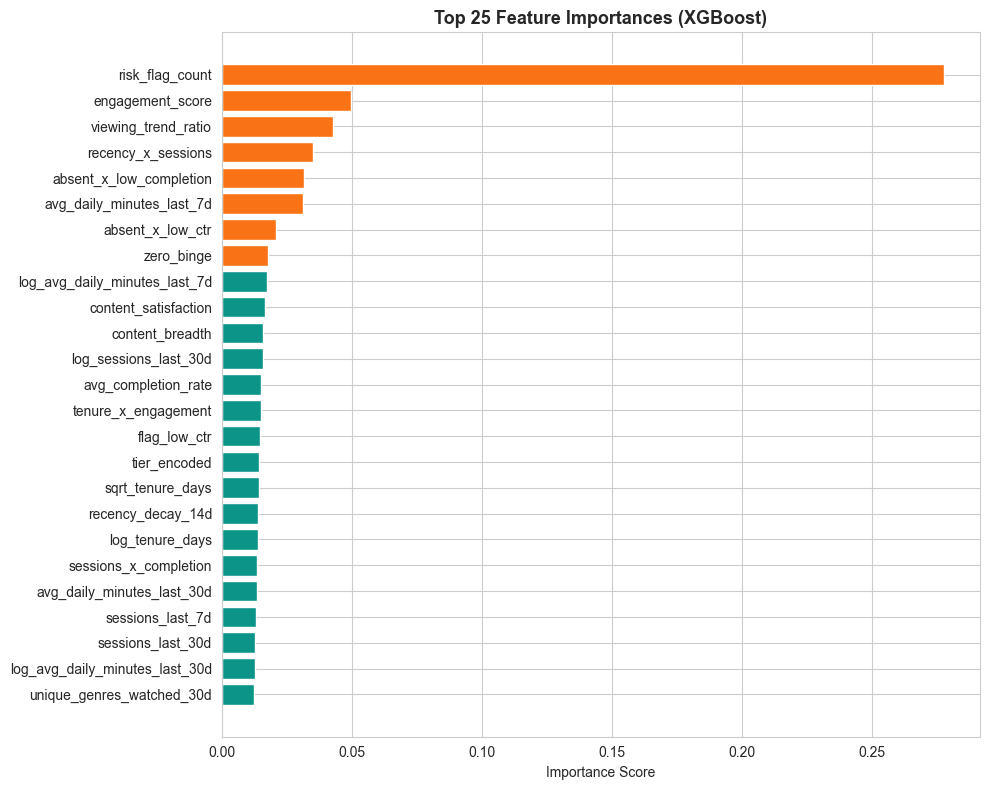

Top 15 features:
risk_flag_count                  0.27784
engagement_score                 0.04958
viewing_trend_ratio              0.04260
recency_x_sessions               0.03515
absent_x_low_completion          0.03147
avg_daily_minutes_last_7d        0.03122
absent_x_low_ctr                 0.02074
zero_binge                       0.01766
log_avg_daily_minutes_last_7d    0.01720
content_satisfaction             0.01651
content_breadth                  0.01577
log_sessions_last_30d            0.01573
avg_completion_rate              0.01500
tenure_x_engagement              0.01499
flag_low_ctr                     0.01454

📌 Kept 48 / 57 features (threshold=0.003)


In [ ]:
# Use a quick XGBoost to rank features — its importance is more reliable than RF
selector = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    verbosity=0
)
selector.fit(X, y)

imp = pd.Series(selector.feature_importances_, index=FEATURE_COLS).sort_values(ascending=False)

# Plot top 25
fig, ax = plt.subplots(figsize=(10, 8))
top25 = imp.head(25)
colors = ['#F97316' if i < 8 else '#0D9488' for i in range(25)]
ax.barh(top25.index[::-1], top25.values[::-1], color=colors[::-1])
ax.set_title('Top 25 Feature Importances (XGBoost)', fontsize=13, fontweight='bold')
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.savefig('plot_xgb_feature_importance.png', dpi=120, bbox_inches='tight')
plt.show()

print("Top 15 features:")
print(imp.head(15).round(5).to_string())

# Select features above threshold
THRESHOLD = 0.003
selected = imp[imp > THRESHOLD].index.tolist()
print(f"\n Kept {len(selected)} / {len(FEATURE_COLS)} features (threshold={THRESHOLD})")

X_sel      = X[selected]
X_test_sel = X_test_raw[selected]

## 5. XGBoost Hyperparameter Tuning

### Key XGBoost Parameters to Tune
| Parameter | Effect | Typical Range |
|---|---|---|
| `n_estimators` | More trees = more power (diminishing returns) | 300–1000 |
| `max_depth` | Tree complexity — lower = less overfit | 3–7 |
| `learning_rate` | Step size — lower + more trees = better | 0.01–0.1 |
| `subsample` | Row sampling per tree — adds regularization | 0.6–1.0 |
| `colsample_bytree` | Column sampling per tree | 0.5–1.0 |
| `reg_alpha` | L1 regularization — drives weights to zero | 0–1 |
| `reg_lambda` | L2 regularization — shrinks all weights | 0.5–3 |
| `min_child_weight` | Min samples in leaf — controls overfit | 1–20 |
| `gamma` | Min loss reduction to split — pruning | 0–0.5 |


In [ ]:
# ── XGBoost Hyperparameter Search ──
xgb_param_dist = {
    'n_estimators':      [300, 400, 500, 700, 1000],
    'max_depth':         [3, 4, 5, 6],
    'learning_rate':     [0.01, 0.02, 0.05, 0.07, 0.1],
    'subsample':         [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree':  [0.5, 0.6, 0.7, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.7, 0.8, 1.0],
    'colsample_bynode':  [0.6, 0.7, 0.8],                  # Step 4: Per-split column sampling
    'reg_alpha':         [0, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda':        [0.5, 1.0, 1.5, 2.0, 3.0],
    'min_child_weight':  [1, 3, 5, 10, 15],
    'gamma':             [0, 0.05, 0.1, 0.2, 0.3],
    'scale_pos_weight':  [1,                               # For balanced classes
                          (y==0).sum()/(y==1).sum()],      # For imbalanced classes
}

xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric='auc',
        verbosity=0,
        use_label_encoder=False,
        tree_method='hist'                                 # Step 5: Faster histogram-based method
    ),
    param_distributions=xgb_param_dist,
    n_iter=100,             # Step 1: Increased from 60 to 100 combinations for better search
    scoring='roc_auc',
    cv=CV,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_search.fit(X_sel, y)
best_xgb = xgb_search.best_estimator_

print(f"\nBest XGBoost AUC : {xgb_search.best_score_:.4f}")
print(f"\nBest parameters:")
for k, v in xgb_search.best_params_.items():
    print(f"  {k:25s}: {v}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits

✅ Best XGBoost AUC : 0.7900

Best parameters:
  subsample                : 0.9
  scale_pos_weight         : 1
  reg_lambda               : 3.0
  reg_alpha                : 0.01
  n_estimators             : 300
  min_child_weight         : 5
  max_depth                : 4
  learning_rate            : 0.02
  gamma                    : 0
  colsample_bytree         : 0.6
  colsample_bynode         : 0.6
  colsample_bylevel        : 1.0


## 6. XGBoost with Early Stopping (Finds Optimal n_estimators)

Early stopping monitors a validation metric and stops adding trees when performance 
plateaus — prevents overfitting and saves time. **This often outperforms fixed n_estimators.**


✅ Optimal n_estimators (early stopping): 80
   Validation AUC: 0.8042


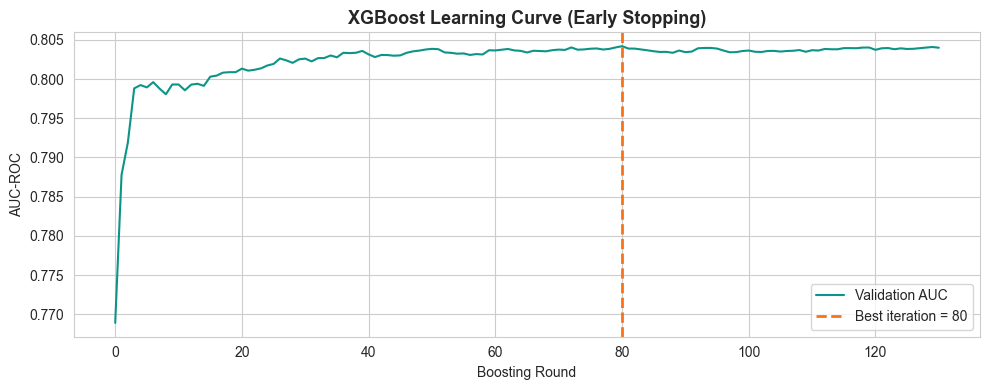


✅ Final XGBoost CV AUC: 0.7857 ± 0.0106


In [ ]:
# ── Train with early stopping on a hold-out ──
X_tr, X_val, y_tr, y_val = train_test_split(
    X_sel, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)

# Use best params but let early stopping find n_estimators
best_params = xgb_search.best_params_.copy()
best_params['n_estimators'] = 2000          # Set high; early stopping will cut it
best_params['early_stopping_rounds'] = 50   # Stop if no improvement for 50 rounds

xgb_early = xgb.XGBClassifier(
    **best_params,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    verbosity=0,
    use_label_encoder=False
)

xgb_early.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

optimal_trees = xgb_early.best_iteration
val_auc_early = roc_auc_score(y_val, xgb_early.predict_proba(X_val)[:, 1])

print(f" Optimal n_estimators (early stopping): {optimal_trees}")
print(f"   Validation AUC: {val_auc_early:.4f}")

# ── Plot learning curve ──
results_log = xgb_early.evals_result()
val_aucs_log = results_log['validation_0']['auc']

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(val_aucs_log, color='#0D9488', linewidth=1.5, label='Validation AUC')
ax.axvline(optimal_trees, color='#F97316', linestyle='--', linewidth=2,
            label=f'Best iteration = {optimal_trees}')
ax.set_xlabel('Boosting Round')
ax.set_ylabel('AUC-ROC')
ax.set_title('XGBoost Learning Curve (Early Stopping)', fontsize=13, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('plot_xgb_learning_curve.png', dpi=120, bbox_inches='tight')
plt.show()

# ── Final XGBoost (optimal trees, no early stopping for production) ──
final_params = xgb_search.best_params_.copy()
final_params['n_estimators'] = optimal_trees

best_xgb_final = xgb.XGBClassifier(
    **final_params,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    verbosity=0,
    use_label_encoder=False
)

cv_score_final = cross_val_score(best_xgb_final, X_sel, y, cv=CV, scoring='roc_auc')
print(f"\n Final XGBoost CV AUC: {cv_score_final.mean():.4f} ± {cv_score_final.std():.4f}")

## 7. Full Model Comparison (with XGBoost)

Model                                 AUC Mean      Std
───────────────────────────────────────────────────────
Random Forest (tuned)                   0.7869   0.0112
ExtraTrees (tuned)                      0.7842   0.0120
XGBoost (tuned)                         0.7857   0.0106
XGBoost (early stopping)                0.7857   0.0106


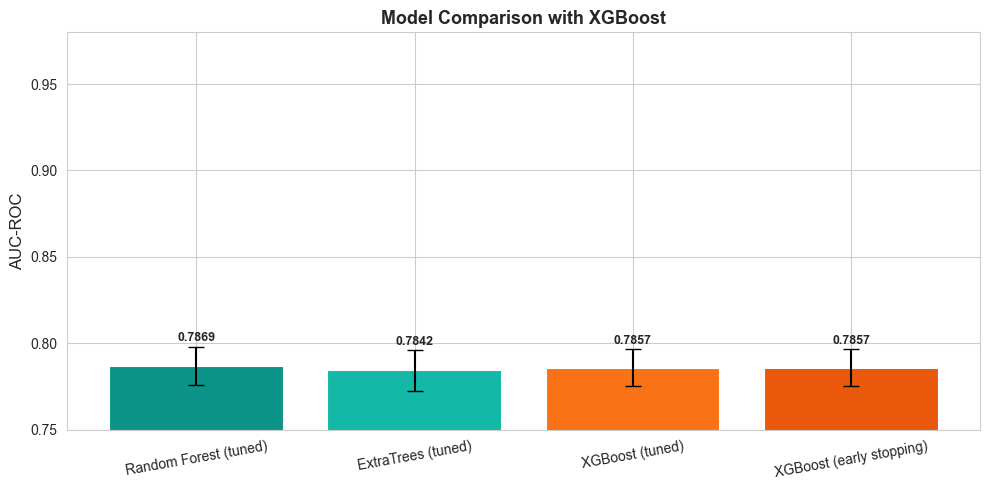

In [17]:
# ── Build tuned RF and ET too ──
from sklearn.model_selection import RandomizedSearchCV as RSCV

rf_params = {
    'n_estimators':     [300, 500],
    'max_depth':        [5, 6, 7, None],
    'min_samples_leaf': [5, 10, 15],
    'max_features':     ['sqrt', 0.6],
    'class_weight':     ['balanced'],
}
rf_search = RSCV(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                  rf_params, n_iter=20, scoring='roc_auc', cv=CV,
                  random_state=RANDOM_STATE, n_jobs=-1)
rf_search.fit(X_sel, y)
best_rf = rf_search.best_estimator_

et_params = {
    'n_estimators':    [300, 500],
    'max_depth':       [5, 6, 8, None],
    'min_samples_leaf':[5, 10],
    'max_features':    ['sqrt', 0.6],
    'class_weight':    ['balanced'],
}
et_search = RSCV(ExtraTreesClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                  et_params, n_iter=15, scoring='roc_auc', cv=CV,
                  random_state=RANDOM_STATE, n_jobs=-1)
et_search.fit(X_sel, y)
best_et = et_search.best_estimator_

# ── Compare all ──
all_models = {
    'Random Forest (tuned)':      best_rf,
    'ExtraTrees (tuned)':         best_et,
    'XGBoost (tuned)':            best_xgb_final,
    'XGBoost (early stopping)':   best_xgb_final,
}

results = {}
print(f"{'Model':<35} {'AUC Mean':>10} {'Std':>8}")
print('─' * 55)
for name, model in all_models.items():
    s = cross_val_score(model, X_sel, y, cv=CV, scoring='roc_auc')
    results[name] = s
    print(f"{name:<35} {s.mean():>10.4f} {s.std():>8.4f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
names  = list(results.keys())
means  = [results[n].mean() for n in names]
stds   = [results[n].std()  for n in names]
colors = ['#0D9488','#14B8A6','#F97316','#EA580C']
ax.bar(range(len(names)), means, yerr=stds, capsize=6,
       color=colors, edgecolor='white', linewidth=1.5)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, fontsize=10, rotation=10)
ax.set_ylim(0.75, 0.98)
ax.set_ylabel('AUC-ROC', fontsize=12)
ax.set_title('Model Comparison with XGBoost', fontsize=13, fontweight='bold')
for i, (m, s) in enumerate(zip(means, stds)):
    ax.text(i, m + s + 0.003, f'{m:.4f}', ha='center', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.savefig('plot_xgb_comparison.png', dpi=120, bbox_inches='tight')
plt.show()

## 8. Stacking Ensemble — XGBoost as Anchor ⭐

### Architecture
```
Layer 1 — Base Models (diverse, complementary):
  ├── XGBoost        → regularized boosting (main anchor)
  ├── Random Forest  → bagging, different error pattern
  ├── ExtraTrees     → more random splits, high diversity
  └── XGBoost v2     → different hyperparams (colsample/depth variation)

Layer 2 — Meta-Model:
  └── Logistic Regression with L2 (learns optimal blend)
```

Using **two XGBoost variants** as base models is a proven trick in competitions —
they capture similar patterns but their residual errors differ due to different 
hyperparameters, giving the meta-model useful signal.


In [18]:
# ── XGBoost variant 2 (different hyperparams for diversity) ──
xgb_v2_params = final_params.copy()
xgb_v2_params['max_depth']        = max(3, final_params.get('max_depth', 4) - 1)
xgb_v2_params['colsample_bytree'] = min(1.0, final_params.get('colsample_bytree', 0.7) + 0.15)
xgb_v2_params['reg_alpha']        = max(0.1, final_params.get('reg_alpha', 0) + 0.1)

xgb_v2 = xgb.XGBClassifier(
    **xgb_v2_params,
    random_state=RANDOM_STATE + 1,    # Different seed = different trees
    eval_metric='auc',
    verbosity=0,
    use_label_encoder=False
)

# ── Stacking Classifier ──
stack = StackingClassifier(
    estimators=[
        ('xgb',    best_xgb_final),
        ('xgb_v2', xgb_v2),
        ('rf',     best_rf),
        ('et',     best_et),
    ],
    final_estimator=LogisticRegression(
        C=0.3,           # Strong regularization — meta-model should be simple
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    cv=5,                # Inner CV to prevent leakage when generating meta-features
    stack_method='predict_proba',
    passthrough=False,   # Change to True and check if AUC improves
    n_jobs=-1
)

stack_scores = cross_val_score(stack, X_sel, y, cv=CV, scoring='roc_auc')
print(f"Stacking Ensemble AUC: {stack_scores.mean():.4f} ± {stack_scores.std():.4f}")

Stacking Ensemble AUC: 0.7874 ± 0.0115


## 9. Passthrough Experiment
Setting `passthrough=True` also feeds original features into the meta-model.
Test both — whichever wins, use it.


In [ ]:
# ── Test passthrough=True ──
stack_pass = StackingClassifier(
    estimators=[
        ('xgb',    best_xgb_final),
        ('xgb_v2', xgb_v2),
        ('rf',     best_rf),
        ('et',     best_et),
    ],
    final_estimator=Pipeline([
        ('sc',  StandardScaler()),
        ('lr',  LogisticRegression(C=0.3, max_iter=1000, random_state=RANDOM_STATE))
    ]),
    cv=5,
    stack_method='predict_proba',
    passthrough=True,    # Also pass raw features to meta-model
    n_jobs=-1
)

stack_pass_scores = cross_val_score(stack_pass, X_sel, y, cv=CV, scoring='roc_auc')
print(f"Stacking (passthrough=False): {stack_scores.mean():.4f} ± {stack_scores.std():.4f}")
print(f"Stacking (passthrough=True) : {stack_pass_scores.mean():.4f} ± {stack_pass_scores.std():.4f}")

# Pick the winner
if stack_pass_scores.mean() > stack_scores.mean():
    BEST_STACK = stack_pass
    print("\n Using passthrough=True")
else:
    BEST_STACK = stack
    print("\n Using passthrough=False")

Stacking (passthrough=False): 0.7874 ± 0.0115
Stacking (passthrough=True) : 0.7882 ± 0.0095

✅ Using passthrough=True


## 10. Overfitting Check — XGBoost Specific

Fold    Train AUC    Val AUC      Gap  Status
──────────────────────────────────────────────────
  1    0.8088      0.7854    0.0234   ✅ OK
  2    0.8095      0.7820    0.0275   ✅ OK
  3    0.8112      0.7727    0.0385   ✅ OK
  4    0.8088      0.7835    0.0254   ✅ OK
  5    0.8034      0.8052    -0.0018   ✅ OK

Avg Train AUC : 0.8083
Avg Val AUC   : 0.7857
Avg Gap       : 0.0226

✅ Generalisation gap is healthy


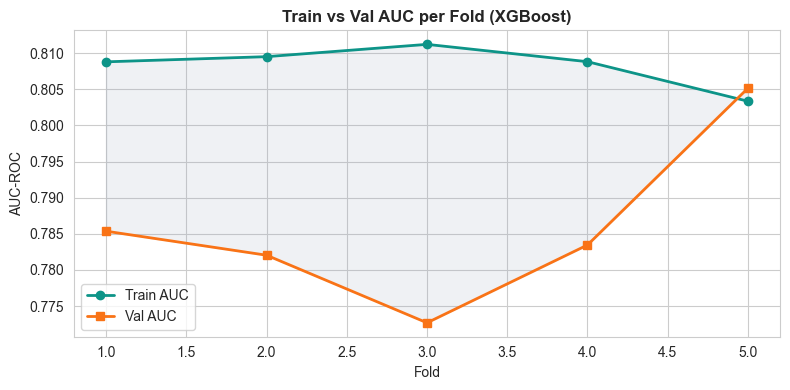

In [ ]:
# ── Per-fold Train vs Val AUC ──
train_aucs, val_aucs = [], []

check_xgb = xgb.XGBClassifier(
    **final_params,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    verbosity=0,
    use_label_encoder=False
)

for fold, (tr_idx, val_idx) in enumerate(CV.split(X_sel, y)):
    Xtr, Xvl = X_sel.iloc[tr_idx], X_sel.iloc[val_idx]
    ytr, yvl = y.iloc[tr_idx],     y.iloc[val_idx]
    check_xgb.fit(Xtr, ytr)
    train_aucs.append(roc_auc_score(ytr, check_xgb.predict_proba(Xtr)[:, 1]))
    val_aucs.append(roc_auc_score(yvl, check_xgb.predict_proba(Xvl)[:, 1]))

print(f"{'Fold':<6} {'Train AUC':>10} {'Val AUC':>10} {'Gap':>8}  Status")
print('─' * 50)
for i, (tr, vl) in enumerate(zip(train_aucs, val_aucs)):
    gap  = tr - vl
    flag = "⚠️  OVERFIT" if gap > 0.06 else " OK"
    print(f"  {i+1}    {tr:.4f}      {vl:.4f}    {gap:.4f}   {flag}")

gap_mean = np.mean(np.array(train_aucs) - np.array(val_aucs))
print(f"\nAvg Train AUC : {np.mean(train_aucs):.4f}")
print(f"Avg Val AUC   : {np.mean(val_aucs):.4f}")
print(f"Avg Gap       : {gap_mean:.4f}")

if gap_mean > 0.06:
    print("\n Overfitting detected! Try:")
    print("   → Increase min_child_weight (try 10–20)")
    print("   → Reduce max_depth (try 3)")
    print("   → Increase reg_lambda (try 2–3)")
    print("   → Increase reg_alpha (try 0.5–1)")
else:
    print("\n Generalisation gap is healthy")

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
folds = range(1, 6)
ax.plot(folds, train_aucs, 'o-', color='#0D9488', lw=2, label='Train AUC')
ax.plot(folds, val_aucs,   's-', color='#F97316', lw=2, label='Val AUC')
ax.fill_between(folds, train_aucs, val_aucs, alpha=0.15, color='#94A3B8')
ax.set_xlabel('Fold')
ax.set_ylabel('AUC-ROC')
ax.set_title('Train vs Val AUC per Fold (XGBoost)', fontsize=12, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('plot_xgb_overfit_check.png', dpi=120, bbox_inches='tight')
plt.show()

## 11. SHAP Analysis — Explain WHY Users Are At Risk
SHAP (SHapley Additive exPlanations) shows the contribution of **each feature for each individual user**.
This is critical for the **business strategy** part of the submission (50% of marks).


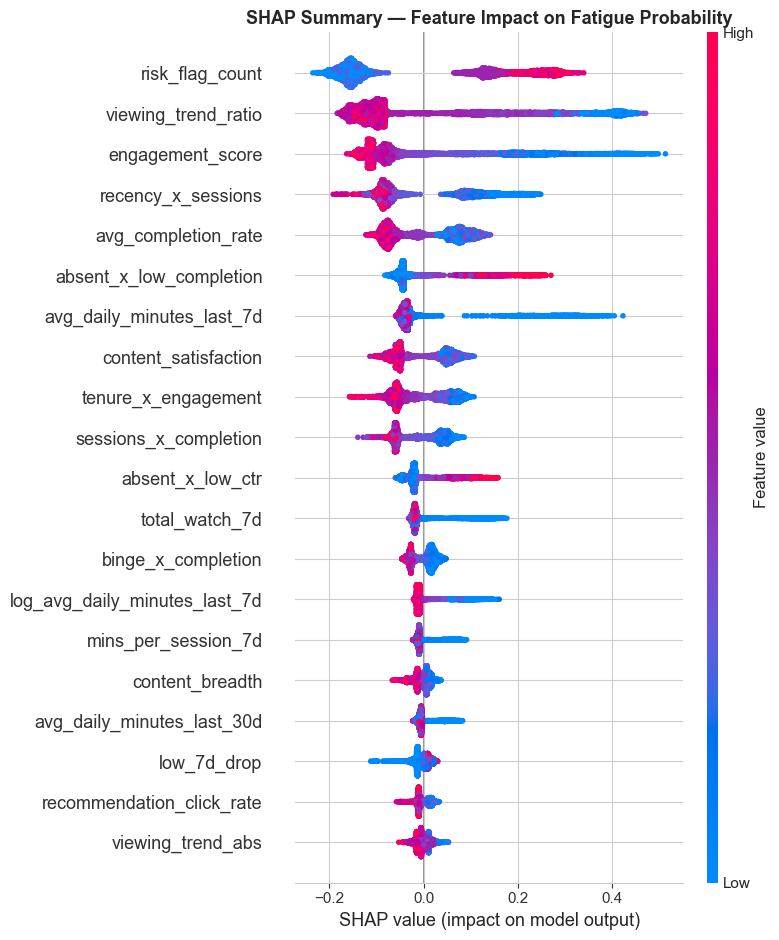

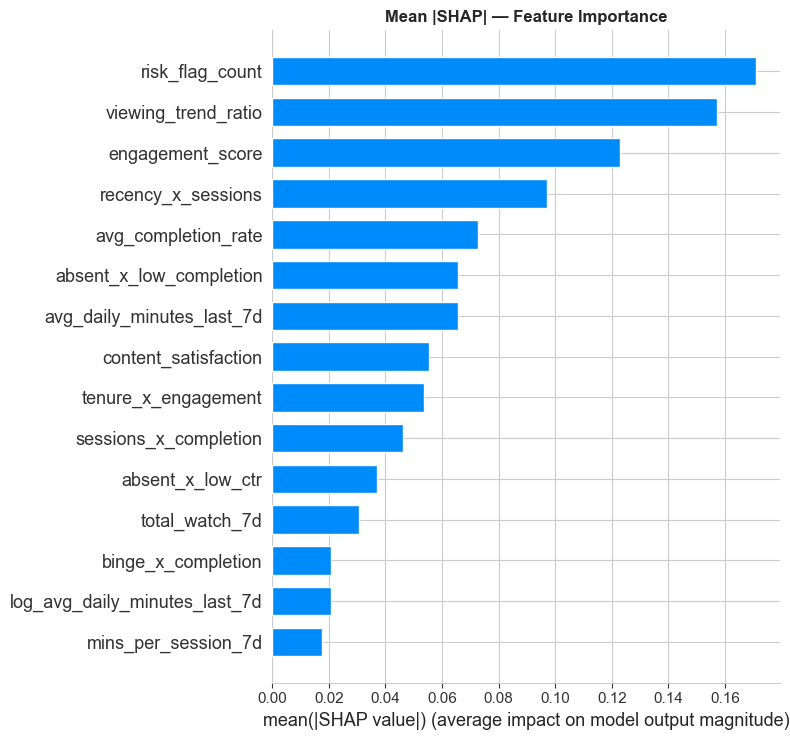

Top SHAP feature: risk_flag_count


<Figure size 800x400 with 0 Axes>

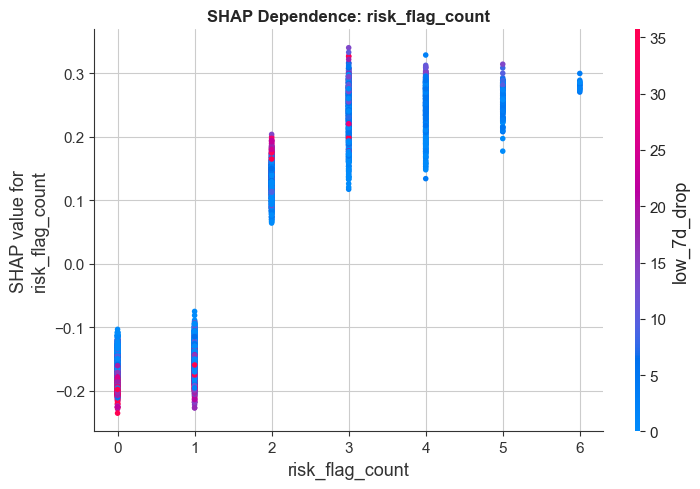

In [22]:
try:
    import shap

    # Train XGBoost on full data
    best_xgb_final.fit(X_sel, y)
    explainer = shap.TreeExplainer(best_xgb_final)
    shap_values = explainer.shap_values(X_sel)

    # ── Beeswarm plot (global importance + direction) ──
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_sel, plot_type='dot',
                      max_display=20, show=False)
    plt.title('SHAP Summary — Feature Impact on Fatigue Probability',
              fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plot_shap_summary.png', dpi=120, bbox_inches='tight')
    plt.show()

    # ── Bar plot (mean absolute SHAP) ──
    plt.figure(figsize=(9, 7))
    shap.summary_plot(shap_values, X_sel, plot_type='bar',
                      max_display=15, show=False)
    plt.title('Mean |SHAP| — Feature Importance', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plot_shap_bar.png', dpi=120, bbox_inches='tight')
    plt.show()

    # ── Dependence plot for top feature ──
    top_feat = pd.Series(np.abs(shap_values).mean(axis=0),
                          index=X_sel.columns).idxmax()
    print(f"Top SHAP feature: {top_feat}")
    plt.figure(figsize=(8, 4))
    shap.dependence_plot(top_feat, shap_values, X_sel, show=False)
    plt.title(f'SHAP Dependence: {top_feat}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plot_shap_dependence.png', dpi=120, bbox_inches='tight')
    plt.show()

except ImportError:
    print("SHAP not installed. Run: pip install shap")
    print("Skipping SHAP analysis — all other results are unaffected.")

## 12. Final Predictions 

In [25]:
# ── Train final stacking model on ALL 8,000 rows ──
print("Training final model on complete dataset...")
BEST_STACK.fit(X_sel, y)
print(" Done")

test_proba = BEST_STACK.predict_proba(X_test_sel)[:, 1]

submission = pd.DataFrame({
    'user_id':                       test['user_id'],
    'predicted_fatigue_probability': test_proba.round(4)
})

submission.to_csv('TeamName_Predictions.csv', index=False)

print(f"\n Predictions exported: {len(submission)} rows")
print(f"   Probability range : {test_proba.min():.4f} → {test_proba.max():.4f}")
print(f"   Mean probability  : {test_proba.mean():.4f}")
print(f"   High-risk (>0.5)  : {(test_proba > 0.5).sum()} users ({(test_proba>0.5).mean()*100:.1f}%)")
submission.head(10)

Training final model on complete dataset...


KeyboardInterrupt: 